In [1]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np

from romgw.config.constants import PROJECT_ROOT, COMMON_TIME, MODE_VALUES
from romgw.config.types import (
    RealArray,
    BBHSpinType,
    DatasetType,
    ModeType,
    ComponentType,
)
from romgw.config.validation import (
    validate_literal,
    validate_dependent_literal,
)
from romgw.waveform.dataset import ComponentWaveformDataset, FullWaveformDataset

In [2]:
import romgw.plotting.custom_config

In [3]:
bbh_spin = "NS"
dataset = "train_xl"
mode = "2,2"
component = "amplitude"

In [4]:
def plot_empirical_time_nodes(
    bbh_spin: BBHSpinType,
    dataset: DatasetType,
    mode: ModeType,
    component: ComponentType,
    verbose:bool = False,
) -> None:
    """Look into the waveforms generated by the fiducial model."""
    # ----- Validate args -----
    bbh_spin = validate_literal(
        value=bbh_spin,
        literal_type=BBHSpinType,
    )
    dataset = validate_literal(
        value=dataset,
        literal_type=DatasetType,
    )
    mode = validate_dependent_literal(
        value=mode,
        literal_type=ModeType,
        parent_value=bbh_spin,
        parent_literal_type=BBHSpinType,
        dependency_map=MODE_VALUES,
    )
    component = validate_literal(
        value=component,
        literal_type=ComponentType,
    )

    # ----- Notebook data root -----
    data_dir = PROJECT_ROOT / "data" / bbh_spin / dataset

    # ----- Load empirical time nodes -----
    ei_dir = data_dir / mode / component / "empirical_interpolation"
    etns = np.load(ei_dir / "empirical_time_nodes.npy")
    print(f"{etns=}")

    # ----- Visualise n waveforms -----
    fig, ax = plt.subplots(1, 1, figsize=(12, 0.5))
    
    ax.scatter(COMMON_TIME[etns], np.zeros_like(etns), marker='x', c='w')

    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    ax.set_xlim(-5000, 250)
    ax.set_xlabel(r"$t$")
    ax.set_title(f"empirical times ({bbh_spin=}, {mode=}, {component=})")

    plt.show()

etns=array([5000, 4343, 5019, 4978, 5008,    1, 4743,  225, 4989,  353, 4694,
       3956, 4996, 1748, 2267, 2734, 4672, 1238, 4939, 3214, 4992])


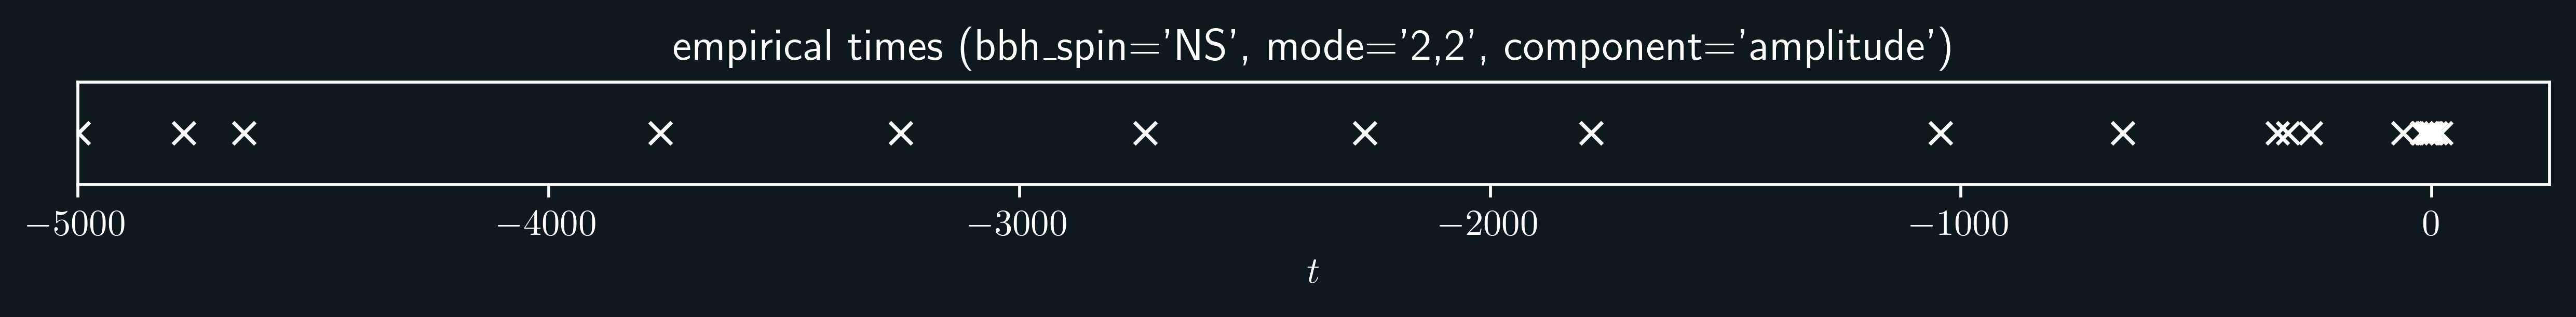

In [5]:
plot_empirical_time_nodes(
    bbh_spin=bbh_spin,
    dataset=dataset,
    mode=mode,
    component=component,
)

In [10]:
def probe_empirical_time_node_selection(
    bbh_spin: BBHSpinType,
    dataset: DatasetType,
    mode: ModeType,
    component: ComponentType,
    verbose:bool = False,
) -> None:
    """"""
    bbh_spin = validate_literal(
        value=bbh_spin,
        literal_type=BBHSpinType,
    )
    dataset = validate_literal(
        value=dataset,
        literal_type=DatasetType,
    )
    mode = validate_dependent_literal(
        value=mode,
        literal_type=ModeType,
        parent_value=bbh_spin,
        parent_literal_type=BBHSpinType,
        dependency_map=MODE_VALUES,
    )
    component = validate_literal(
        value=component,
        literal_type=ComponentType,
    )

    # ----- Notebook data root -----
    data_dir = PROJECT_ROOT / "data" / bbh_spin / dataset

    # ----- Load reduced basis elements -----
    rb_dir = data_dir / mode / component / "reduced_basis" / "elements"
    rb = ComponentWaveformDataset.from_directory(rb_dir, component=component)


    # ----- Initialise objects for greedy algorithm -----
    rb_arr = rb.array
    m, L = rb_arr.shape
    etns: list[int] = []

    # ----- Select 0-th node -----
    v0 = rb_arr[0].copy()  # 0-th rb element
    I = np.zeros_like(v0)  # no B matrix to find the empirical interpolant yet
    r0 = I - v0  # minimise this (aiming for I ~= v)
    
    # The 0-th node is unique by definition
    node0 = np.argmax(np.abs(r0))  # node which most needs additional 'help'
    etns.append(node0.astype(int))

    V_inv = np.linalg.inv(rb_arr[:1, etns].T)  # init V_inv with 0-th node
    B = rb_arr[:1, :].T @ V_inv  # init B with 0-th node


    # ----- Visualise n waveforms -----
    fig = plt.figure(figsize=(12, 3*m))
    spec = gridspec.GridSpec(
        ncols=1,
        nrows=m,
        height_ratios=(*[3 for _ in range(m)],),
        left=0,
        right=1,
        hspace=0.6
    )

    ax = fig.add_subplot(spec[0])
    ax.plot(COMMON_TIME, np.zeros_like(COMMON_TIME), linestyle='--', c='w', alpha=0.5)
    ax.plot(COMMON_TIME, I - v0)
    ax.plot(COMMON_TIME, np.abs(I - v0), alpha=0.5, zorder=0)
    ax.scatter(COMMON_TIME[etns[0]], np.abs((I - v0)[etns[0]]), marker='x', c='w')
    ax.set_xlim(-5000, 250)
    ax.set_ylim(-np.abs((I - v0)[etns[0]]), np.abs((I - v0)[etns[0]]))
    ax.set_xlabel(r"$t$")
    r_num = 1
    ax.set_ylabel(rf"$r_{{{r_num}}}$")
    ax.set_title(f"empirical time node (1)")


    # ----- Greedily select k-th nodes -----
    for k in range(1, m):
        v = rb_arr[k].copy()  # k-th rb element
        I = B @ v[etns]  # empirical interpolant
        r = I - v  # minimise this (aiming for I ~= v)
        
        # r[etns] *= 0  # ensure unique node selection
        node = np.argmax(np.abs(r))  # node which most needs additional 'help'
        etns.append(node.astype(int))

        V_inv = np.linalg.inv(rb_arr[:k+1, etns].T)  # find updated V_inv
        B = rb_arr[:k+1, :].T @ V_inv  # find updated B

        ax = fig.add_subplot(spec[k])
        ax.plot(COMMON_TIME, np.zeros_like(COMMON_TIME), linestyle='--', c='w', alpha=0.5)
        ax.plot(COMMON_TIME, I - v)
        ax.plot(COMMON_TIME, np.abs(I - v), alpha=1.0, zorder=0)
        ax.scatter(COMMON_TIME[etns[k]], np.abs((I - v)[etns[k]]), marker='x', c='w')
        ax.set_xlim(-5000, 250)
        ax.set_ylim(-np.abs((I - v)[etns[k]]), np.abs((I - v)[etns[k]]))
        ax.set_xlabel(r"$t$")
        # ax.set_ylabel(f"residual ({k+1})")
        r_num = k + 1
        ax.set_ylabel(rf"$r_{{{r_num}}}$")
        ax.set_title(f"empirical time node ({k+1})")

    plt.show()

In [11]:
probe_empirical_time_node_selection(
    bbh_spin=bbh_spin,
    dataset=dataset,
    mode=mode,
    component=component,
)

Waveforms loaded.                                                               
